In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
import MAPInference as mapi
from matplotlib import pyplot as plt
import pickle
import os
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg
from sklearn.linear_model import LinearRegression as lreg
from sklearn.decomposition import PCA as pca
from scipy.optimize import minimize

import SimulatedSimMats as ssm

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
# df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [4]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']

In [5]:
getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

wallmorphx = lambda s: 1.2*(xfreq(s)-xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))-.1
wallmorphy = lambda s: 1.2*(yfreq(s)-yfreq(-.1))/(yfreq(1.1)-yfreq(-.1))-.1

def trial_info_to_stim(trial_info):
    wall = trial_info['morphs']+trial_info['wallJitter']
    bckgnd = trial_info['morphs']+trial_info['bckgndJitter']
    tower = np.minimum(np.maximum(trial_info['morphs']+trial_info['towerJitter'],0),1)

    return np.concatenate((xfreq(wall)[:,np.newaxis],wall[:,np.newaxis],bckgnd[:,np.newaxis],tower[:,np.newaxis]),axis=1)

def trial_info_to_morph(trial_info):
    wall = trial_info['morphs']+trial_info['wallJitter']
    bckgnd = trial_info['morphs']+trial_info['bckgndJitter']
    tower = np.minimum(np.maximum(trial_info['morphs']+trial_info['towerJitter'],0),1)

    return np.concatenate((wallmorphx(wall)[:,np.newaxis],wallmorphy(wall)[:,np.newaxis],bckgnd[:,np.newaxis],tower[:,np.newaxis]),axis=1)
    
def single_session_data(sess):
#     print(sess)
    VRDat = pp.behavior_dataframe(sess["data file"])
    trial_info, tstarts_, teleports_ = u.by_trial_info(VRDat)
#     return trial_info_to_stim(trial_info)
    return trial_info_to_morph(trial_info)

def single_mouse_data(mouse,df_mouse):
#     df_mouse = df[df["MouseName"]==mouse]
    data = {}
    for i in range(df_mouse.shape[0]):
        sess = df_mouse.iloc[i]
        date, num = sess['DateFolder'],sess['SessionNumber']
        key = date + str(num) 
        
        data[key] = single_session_data(sess)
        
    return data

def single_mouse_em_all(mouse,data = None):
    if data is None:
        data = single_mouse_data(mouse,df[df["MouseName"]==mouse])
    else:
        pass
    
    for i, (key,arr) in enumerate(data.items()):
        if i == 0:
            em_all = arr
        else:
            em_all = np.concatenate((em_all,arr),axis=0)
    return em_all

def gaussian(mu,sigma,x):
    '''radial basis function centered at 'mu' with width 'sigma', sampled at 'x' '''
    return np.exp(-(mu-x)**2/sigma**2)


In [ ]:
#load FFT KNN model
with open("D:\\Morph_Results\\FrameGrabber_FFT_KNNReg_model.pkl",'rb') as f:
    knn_model = pickle.load(f)
print(knn_model.keys())

# show stimulus is essentially 1D

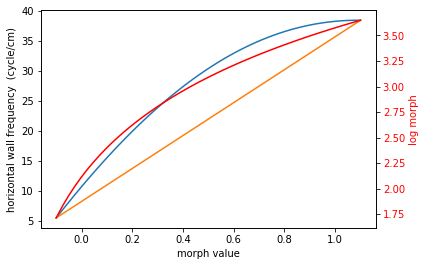

In [6]:
m = np.linspace(-.1,1.1)
f,ax = plt.subplots()
ax.plot(m,xfreq(m))
ax.plot(m,np.linspace(xfreq(-.1),xfreq(1.1)))
ax.set_xlabel('morph value')
ax.set_ylabel('horizontal wall frequency  (cycle/cm)')

ax2= ax.twinx()
ax2.plot(m,np.log(np.linspace(xfreq(-.1),xfreq(1.1))),color='red')
ax2.set_ylabel('log morph',color='red')
ax2.tick_params(axis='y',labelcolor='red')

# ax.legend(('actual','morph'))
# ax2.legend('log(morph)')
f.savefig("D:\\Morph_Results\\figures\\wallmorph.png",format="png")


In [7]:
print(ang(xfreq(1.1),yfreq(1.1)), ang(xfreq(-.1),yfreq(-.1)))

65.0 4.999999999999997


In [35]:
for m, mouse in enumerate(mice):
    
    print(mouse)
    if m ==0:
        EM_all = single_mouse_em_all(mouse)
    else:
        EM_all = np.concatenate((EM_all,single_mouse_em_all(mouse)),axis=0)
    
        



4139265.3


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4139265.4
4139265.5
4222168.1
deleting last index from trial start
deleting last index from trial start
4343703.1
4343706
4222153.1
4222153.2
4222153.3
4222174.1
4222154.1
4343702.1


[[-0.57038834 -0.47796743 -0.47704516 -0.46758121]
 [-0.80659747  0.20170983  0.46650341  0.30180826]
 [-0.15165299  0.79326425 -0.58916754 -0.02479536]
 [ 0.03254264  0.31873519  0.45572369 -0.83046058]]


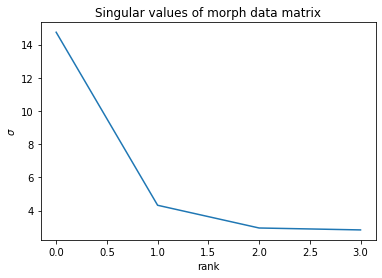

In [43]:
u_,s_,vh_ = np.linalg.svd(EM_all[:,:],full_matrices=False)
f,ax = plt.subplots()
ax.plot(s_**.5)
ax.set_xlabel("rank")
ax.set_ylabel("$\sigma$")
ax.set_title("Singular values of morph data matrix")
f.savefig("D:\\Morph_Results\\stim_singularvalues.png",format="png")
print(vh_)
# vh_norm = -1*vh_
vh_norm = vh_/vh_.sum(axis=1,keepdims=True)

# Make cumulative prior for each session for each mouse

In [6]:
x=np.linspace(-.1,1.1,num=1000)

def cumulative_prior(mouse,df,first_ind=5,sigma=.1,x=np.linspace(-.3,1.3,num=1000)):
    behav_sessions = df[df["MouseName"]==mouse]
    imag_sessions = behav_sessions[behav_sessions['Imaging']==1]
    morph_data = single_mouse_data(mouse,behav_sessions)
    
    PRIORS = []
    for ind in range(first_ind,imag_sessions.shape[0]):
        sess = imag_sessions.iloc[ind]


        # calculate cumulative prior up to current session
        date_folder,sessn = None,-np.inf
        em_all = None
        b_ind = 0
        while date_folder!=sess['DateFolder'] or sessn<sess["SessionNumber"]:
            b_sess = behav_sessions.iloc[b_ind]
            date_folder = b_sess['DateFolder']
            sessn = b_sess['SessionNumber']
            if em_all is None:
                em_all = morph_data[date_folder+str(sessn)]
            else:
                em_all = np.concatenate((em_all,morph_data[date_folder+str(sessn)]),axis=0)
            b_ind+=1

#         feats = np.zeros()
        em_1d = knn_model['model'].predict(em_all)
        print(em_1d.shape)
        
        prior = np.mean(gaussian(em_1d[:,np.newaxis],sigma,x[np.newaxis,:]),axis=0)
        
        PRIORS.append(prior)
        
        
    return PRIORS


    

In [7]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
first_sessions = [5,5,5,3,5,1,4,4,4,4,4,4]
print(len(mice),len(first_sessions))
rare_mice,freq_mice = mice[:6],mice[6:]
rare_fs, freq_fs = first_sessions[:6],first_sessions[6:]
# for mouse in rare_mice:
#     print(mouse)
#     cumulative_prior(mouse,df)

# rare_priors = {mouse:cumulative_prior(mouse,df) for mouse in rare_mice}
# freq_priors = {mouse:cumulative_prior(mouse,df,first_ind=4) for mouse in freq_mice}

12 12


# look at a few example sessions

In [8]:
def single_mouse_sf_regression(mouse,df,first_ind=5,sigma_prior=.1,sigma_likelihood=.1,
                              x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:],mus = np.linspace(-.3,1.3,num=1000)[:,np.newaxis],
                              plot=False):
    behav_sessions = df[df["MouseName"]==mouse]
    imag_sessions = behav_sessions[behav_sessions["Imaging"]==1]
    morph_data = single_mouse_data(mouse,behav_sessions)
    
    WALLMORPH,WALLMORPH_UC, YTARGET, YHAT, PRIORS, SF,SFHAT = [],[],[],[],[],[],[]
    
    for ind in range(first_ind,imag_sessions.shape[0]):
        sess = imag_sessions.iloc[ind]
        
        print(ind)
        # calculate cumulative prior up to current session
        date_folder,sessn = None,-np.inf
        em_all = None
        b_ind = 0
        while date_folder!=sess['DateFolder'] or sessn<sess["SessionNumber"]:
            b_sess = behav_sessions.iloc[b_ind]
            date_folder = b_sess['DateFolder']
            sessn = b_sess['SessionNumber']
            if em_all is None:
                em_all = morph_data[date_folder+str(sessn)]
            else:
                em_all = np.concatenate((em_all,morph_data[date_folder+str(sessn)]),axis=0)
            b_ind+=1


        em_1d = em_all[:,:1]
        prior = np.mean(gaussian(em_1d,sigma_prior,x),axis=0,keepdims=True)
        PRIORS.append(prior)
        prior_spl = lambda x: np.mean(gaussian(em_1d,sigma_prior,x),axis=0,keepdims=True)



        # load data
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        VRDat,S = data['VRDat'],data['S']
        S[np.isnan(S)]=0
        S = S/np.percentile(S,95,axis=0)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        S_trial_mat[np.isnan(S_trial_mat)]=0


        # similarity fraction
        sf = u.similarity_fraction(S_trial_mat,trial_info)
        SF.append(sf)

        morphmat = trial_info_to_morph(data['trial_info'])
        wallMorph = morphmat[:,0]
        WALLMORPH.append(wallMorph)
        WALLMORPH_UC.append(data['trial_info']['morphs']+data['trial_info']['wallJitter'])
    

         # need to add cross val
        ytarget = x[0,np.argmax(prior_spl(x)*gaussian(wallMorph[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
        yhat,sfhat = np.zeros(ytarget.shape),np.zeros(ytarget.shape)
        for trial in range(yhat.shape[0]):
            train = np.ones(yhat.shape)>0
            train[trial]= False
            linmodel = hreg().fit(sf[train,np.newaxis],ytarget[train].ravel())
            yhat[trial]=linmodel.predict(sf[trial].reshape(-1,1))
            
            linmodel = hreg().fit(ytarget[train,np.newaxis],sf[train].ravel())
            sfhat[trial] = linmodel.predict(ytarget[trial].reshape(-1,1))

        YHAT.append(yhat)
        SFHAT.append(sfhat)
       
        
    return {'wallmorph':WALLMORPH, 'ytarget':YTARGET,'yhat': YHAT, 'priors':PRIORS,'sf': SF,'sfhat':SFHAT,'wallmorph_uc':WALLMORPH_UC}

In [10]:
res = single_mouse_sf_regression('4139265.5',df,plot=True)

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9


In [18]:
# single_mouse_sf_regression('4139265.5',df,first_ind=5)
rare_sfreg = {mouse:single_mouse_sf_regression(mouse,df,first_ind=fs) for (mouse,fs) in zip(rare_mice,rare_fs)}
freq_sfreg = {mouse:single_mouse_sf_regression(mouse,df,first_ind=4) for mouse in freq_mice}

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9
10


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


deleting last index from trial start
deleting last index from trial start
3
4
5
6


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


1


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


2
3
4
5
6
7
8


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6
7


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6
7
8


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6
7
8


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4
5
6


In [19]:
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'wb') as f:
    pickle.dump(rare_sfreg,f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'wb') as f:
    pickle.dump(freq_sfreg,f)

In [9]:
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'rb') as f:
    rare_sfreg = pickle.load(f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'rb') as f:
    freq_sfreg = pickle.load(f)

In [10]:
def mean_prior_post(dict_sfreg,sigma_likelihood=.3,x=np.linspace(-.3,1.3,num=1000)[np.newaxis,:]):
    mice = [mouse for mouse in dict_sfreg.keys()]
    priors = np.zeros([len(mice),x.shape[1]])
    for i, (mouse,res) in enumerate(dict_sfreg.items()):
        _prior=None
        for _p in res['priors']:
            if _prior is None:
                _prior = _p
            else:
                _prior+=_p
        _prior = _prior/_prior.sum()
        priors[i,:]=_prior
        
    prior = _prior.mean(axis=0,keepdims=True)
    prior = prior/prior.sum()
    post = prior*gaussian(np.linspace(-.11,1.11,num=1000)[:,np.newaxis],sigma_likelihood,np.linspace(-.3,1.3,num=1000)[np.newaxis,:])
    post = post/post.sum(axis=1)
    return priors, prior, post

In [11]:
rare_priors,rare_prior,rare_post = mean_prior_post(rare_sfreg)
freq_priors,freq_prior,freq_post = mean_prior_post(freq_sfreg)


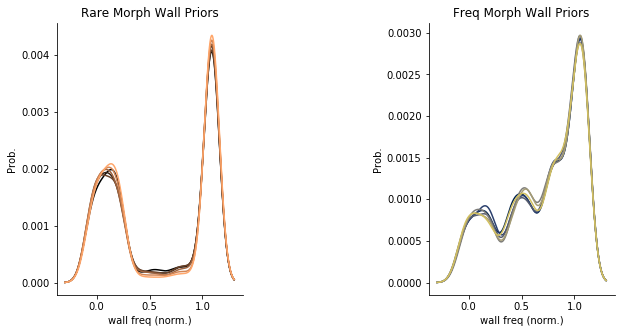

In [12]:
x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
f,ax = plt.subplots(1,2,figsize=[10,5])
for row in range(rare_priors.shape[0]):
    ax[0].plot(x.ravel(),rare_priors[row,:].ravel(),color=plt.cm.copper(np.float(row)/np.float(len(rare_mice))))

for row in range(freq_priors.shape[0]):
    ax[1].plot(x.ravel(),freq_priors[row,:].ravel(),color=plt.cm.cividis(np.float(row)/np.float(len(freq_mice))))


# ax[0].plot(x.ravel(),rare_prior.ravel(),color='brown',linewidth=5)
ax[0].set_xlabel('wall freq (norm.)')
ax[0].set_ylabel('Prob.')
ax[0].set_title('Rare Morph Wall Priors')
# ax[1].plot(x.ravel(),freq_prior.ravel(),color='blue',linewidth=5)
ax[1].set_xlabel('wall freq (norm.)')
ax[1].set_ylabel('Prob.')
ax[1].set_title('Freq Morph Wall Priors')
f.subplots_adjust(wspace=1)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)


f.savefig("D:\\Morph_Results\\priors.pdf",format="pdf")

4139265.3 0.0019817840486111597 0.0017215575828613404 0.14076802119655893
4139265.4 0.0019473362203316896 0.0016504390237034945 0.16542107034308579
4139265.5 0.0021744634666896927 0.0018357333829384609 0.16933788673895098
4222168.1 0.002025543354106242 0.0017466629868965384 0.14813088465774957
4343703.1 0.0019783609075602025 0.0015694372578268594 0.23155155680397915
4343706 0.002068209601909401 0.0018139220012338977 0.13119195384737573


Text(0.5, 1.0, 'Reconstructed Freq Prior vs Ideal Freq. Prior')

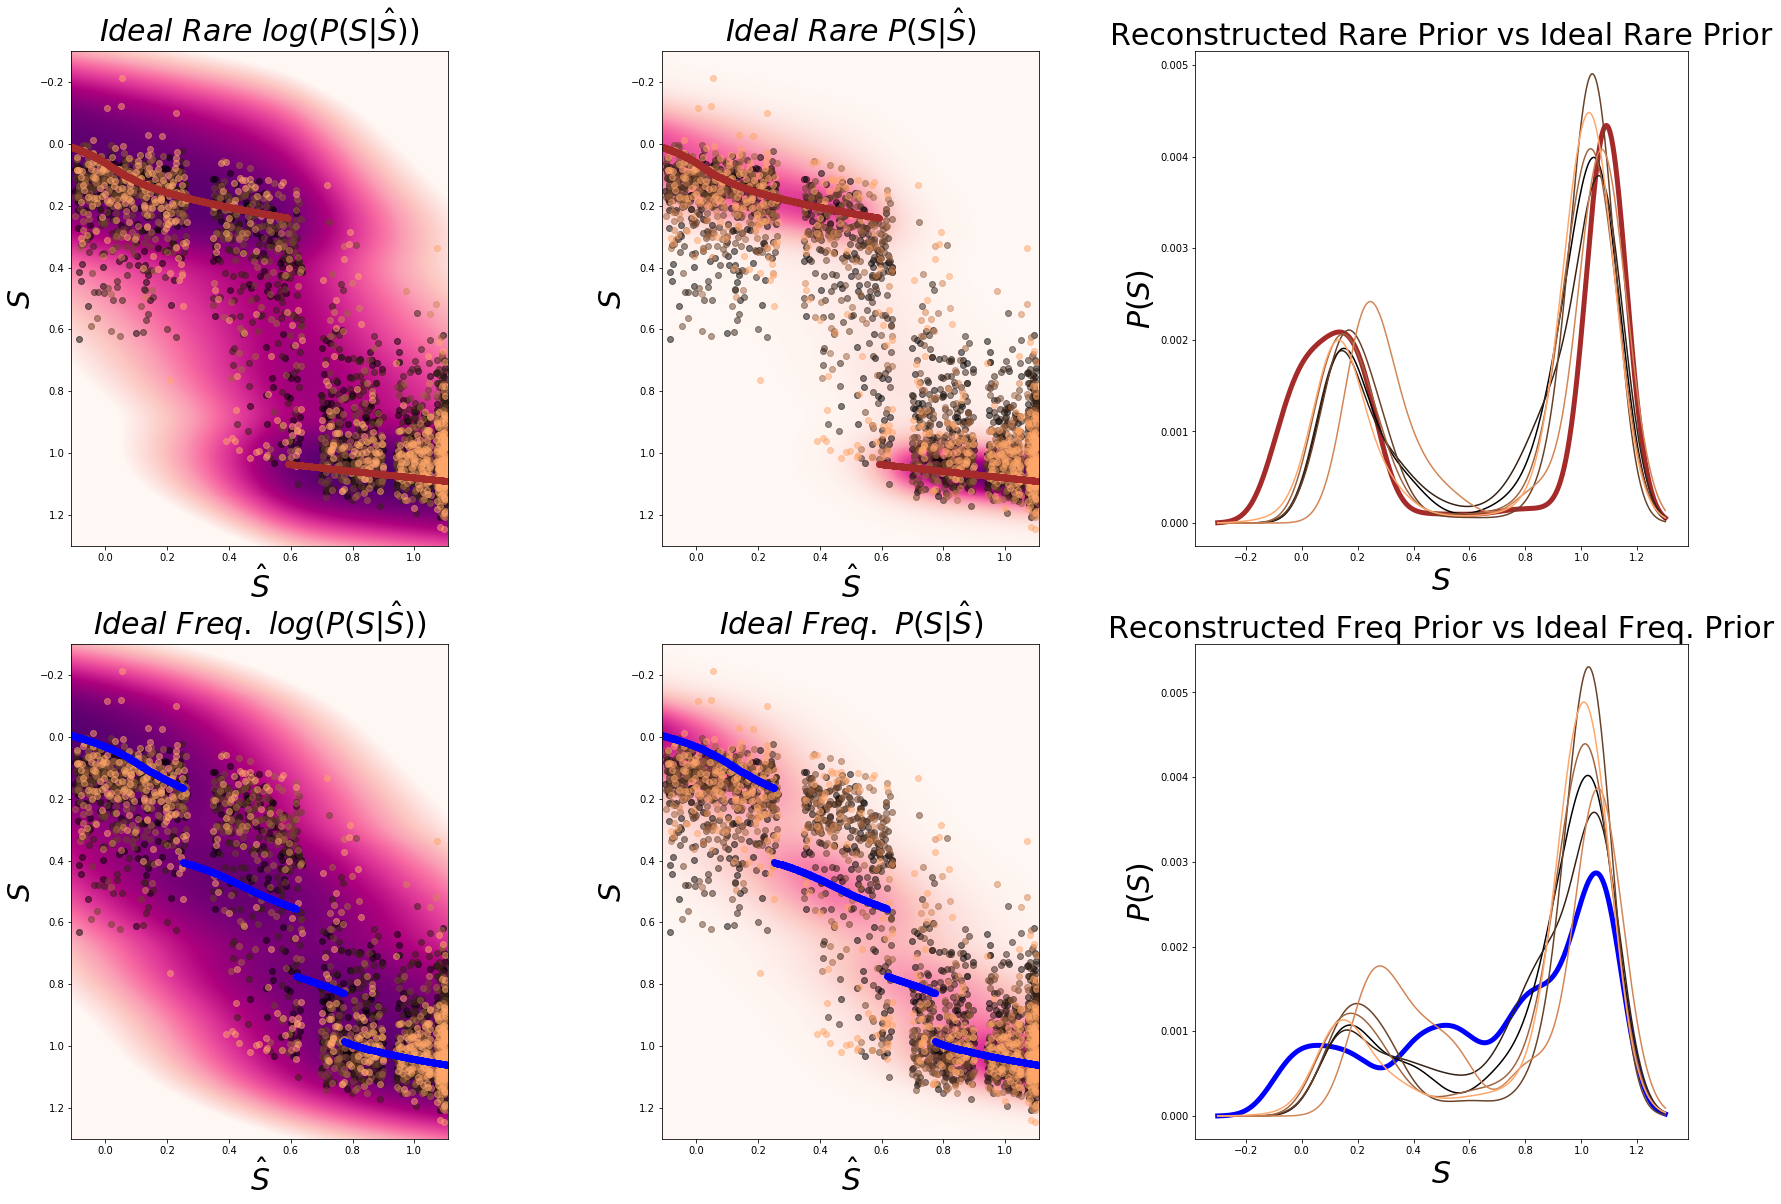

In [49]:
sigma_likelihood=.3


x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
rare_post,xx,Z = ssm.calculate_posterior(rare_prior,x.ravel(),xx_lims = (-.3,1.3),calcZ=True)
rareZspline = spline(x.ravel(),Z)

freq_post,xx,Z = ssm.calculate_posterior(freq_prior,x.ravel(),xx_lims = (-.3,1.3),calcZ=True)
freqZspline = spline(x.ravel(),Z)
f,ax = plt.subplots(2,3,figsize=[30,20])

rare_logpost = np.log(rare_post.T)
# rare_logpost_spline()
ax[0,0].imshow(rare_logpost,vmin=np.percentile(rare_logpost,20),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[0,1].imshow(rare_post.T,vmin=np.percentile(rare_post,5),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[0,2].plot(x.ravel(),rare_prior.ravel(),color='brown',linewidth=5)

freq_logpost = np.log(freq_post.T)
ax[1,0].imshow(freq_logpost,vmin=np.percentile(freq_logpost,20),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[1,1].imshow(freq_post.T,vmin=np.percentile(freq_post,5),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[1,2].plot(x.ravel(),freq_prior.ravel(),color='blue',linewidth=5)

for i, (mouse, res) in enumerate(rare_sfreg.items()):
    _wallmorph = np.concatenate(res['wallmorph'])
    _yhat = np.concatenate(res['yhat'])
    ax[0,0].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    ax[0,1].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,0].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,1].scatter(_wallmorph,_yhat,color=plt.cm.copper(np.float(i/len(rare_mice))),alpha=.5)
    
    raresfsmooth = np.mean(gaussian(_yhat[:,np.newaxis],.1,x),axis=0)/(u.gaussian(x,sigma_likelihood,x[:,np.newaxis])/rareZspline(x)[np.newaxis,:]).sum(axis=1)
    raresfsmooth/=raresfsmooth.sum()
    freqsfsmooth = np.mean(gaussian(_yhat[:,np.newaxis],.1,x),axis=0)/(u.gaussian(x,sigma_likelihood,x[:,np.newaxis])/freqZspline(x)[np.newaxis,:]).sum(axis=1)
    freqsfsmooth/=freqsfsmooth.sum()
    ax[0,2].plot(x.ravel(),raresfsmooth.ravel(),color=plt.cm.copper(np.float(i/len(rare_mice))))
    ax[1,2].plot(x.ravel(),freqsfsmooth.ravel(),color=plt.cm.copper(np.float(i/len(rare_mice))))
    
#     rentr,fentr =sp.special.rel_entr(raresfsmooth,rare_prior).sum(),sp.special.rel_entr(freqsfsmooth,freq_prior).sum()
    rprod,fprod=(rare_prior.ravel()*raresfsmooth.ravel()).sum(),(freq_prior.ravel()*freqsfsmooth.ravel()).sum()
    print(mouse,rprod,fprod,np.log(rprod/fprod))
    

# xx = np.linspace(-.1,1.1,num=1000)
rare_ytarget = x[0,np.argmax(rare_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[0,0].scatter(xx,rare_ytarget,color='brown')
ax[0,1].scatter(xx,rare_ytarget,color='brown')

freq_ytarget = x[0,np.argmax(freq_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[1,0].scatter(xx,freq_ytarget,color='blue')
ax[1,1].scatter(xx,freq_ytarget,color='blue')


ax[0,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,0].set_ylabel("$S$",fontsize=30)
ax[0,0].set_title("$Ideal \  Rare \ log(P(S|\hat{S}))$",fontsize=30)
ax[0,0].set_xlim([-.11,1.11])

ax[0,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,1].set_ylabel("$S$",fontsize=30)
ax[0,1].set_title("$Ideal \  Rare \ P(S|\hat{S})$",fontsize=30)
ax[0,1].set_xlim([-.11,1.11])

ax[0,2].set_xlabel("$S$",fontsize=30)
ax[0,2].set_ylabel("$P(S)$",fontsize=30)
ax[0,2].set_title("Reconstructed Rare Prior vs Ideal Rare Prior",fontsize=30)
# ax[0,2].set_xlim([-.11,1.11])

ax[1,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,0].set_ylabel("$S$",fontsize=30)
ax[1,0].set_title("$Ideal \ Freq. \ log(P(S|\hat{S}))$",fontsize=30)
ax[1,0].set_xlim([-.11,1.11])

ax[1,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,1].set_ylabel("$S$",fontsize=30)
ax[1,1].set_title("$Ideal \ Freq. \ P(S|\hat{S})$",fontsize=30)
ax[1,1].set_xlim([-.11,1.11])

ax[1,2].set_xlabel("$S$",fontsize=30)
ax[1,2].set_ylabel("$P(S)$",fontsize=30)
ax[1,2].set_title("Reconstructed Freq Prior vs Ideal Freq. Prior",fontsize=30)


# f.savefig("D:\\Morph_Results\\figures\\rare_sf_reg_density.png",format="png")
# f.savefig("D:\\Morph_Results\\figures\\rare_sf_reg_density.pdf",format="pdf")

# add estimated density from plotted points
# calculate correlation with either rare or frequent

In [ ]:
for i, (mouse, res) in enumerate(rare_sfreg.items()):
    _wallmorph = np.concatenate(res['wallmorph'])
    _yhat = np.concatenate(res['yhat'])
    
    # entropy of data points / entropy of distribution 
    _x = x.ravel()
    wmsm = u.gaussian(_wallmorph[:,np.newaxis,np.newaxis],.05,)

4222153.1 0.05024932927544944 0.06633681974547115 -0.2777478945543068
4222153.2 0.059286815112340685 0.06993993570736737 -0.16524987321773252
4222153.3 0.02853349287134833 0.05930047973415538 -0.7315388101734583
4222174.1 0.05062439081656104 0.07194509701061226 -0.3514697945129263
4222154.1 0.032027667926089694 0.06579043585046798 -0.7198743240309289
4343702.1 0.04640317719826829 0.06343425796305045 -0.3126361309404001


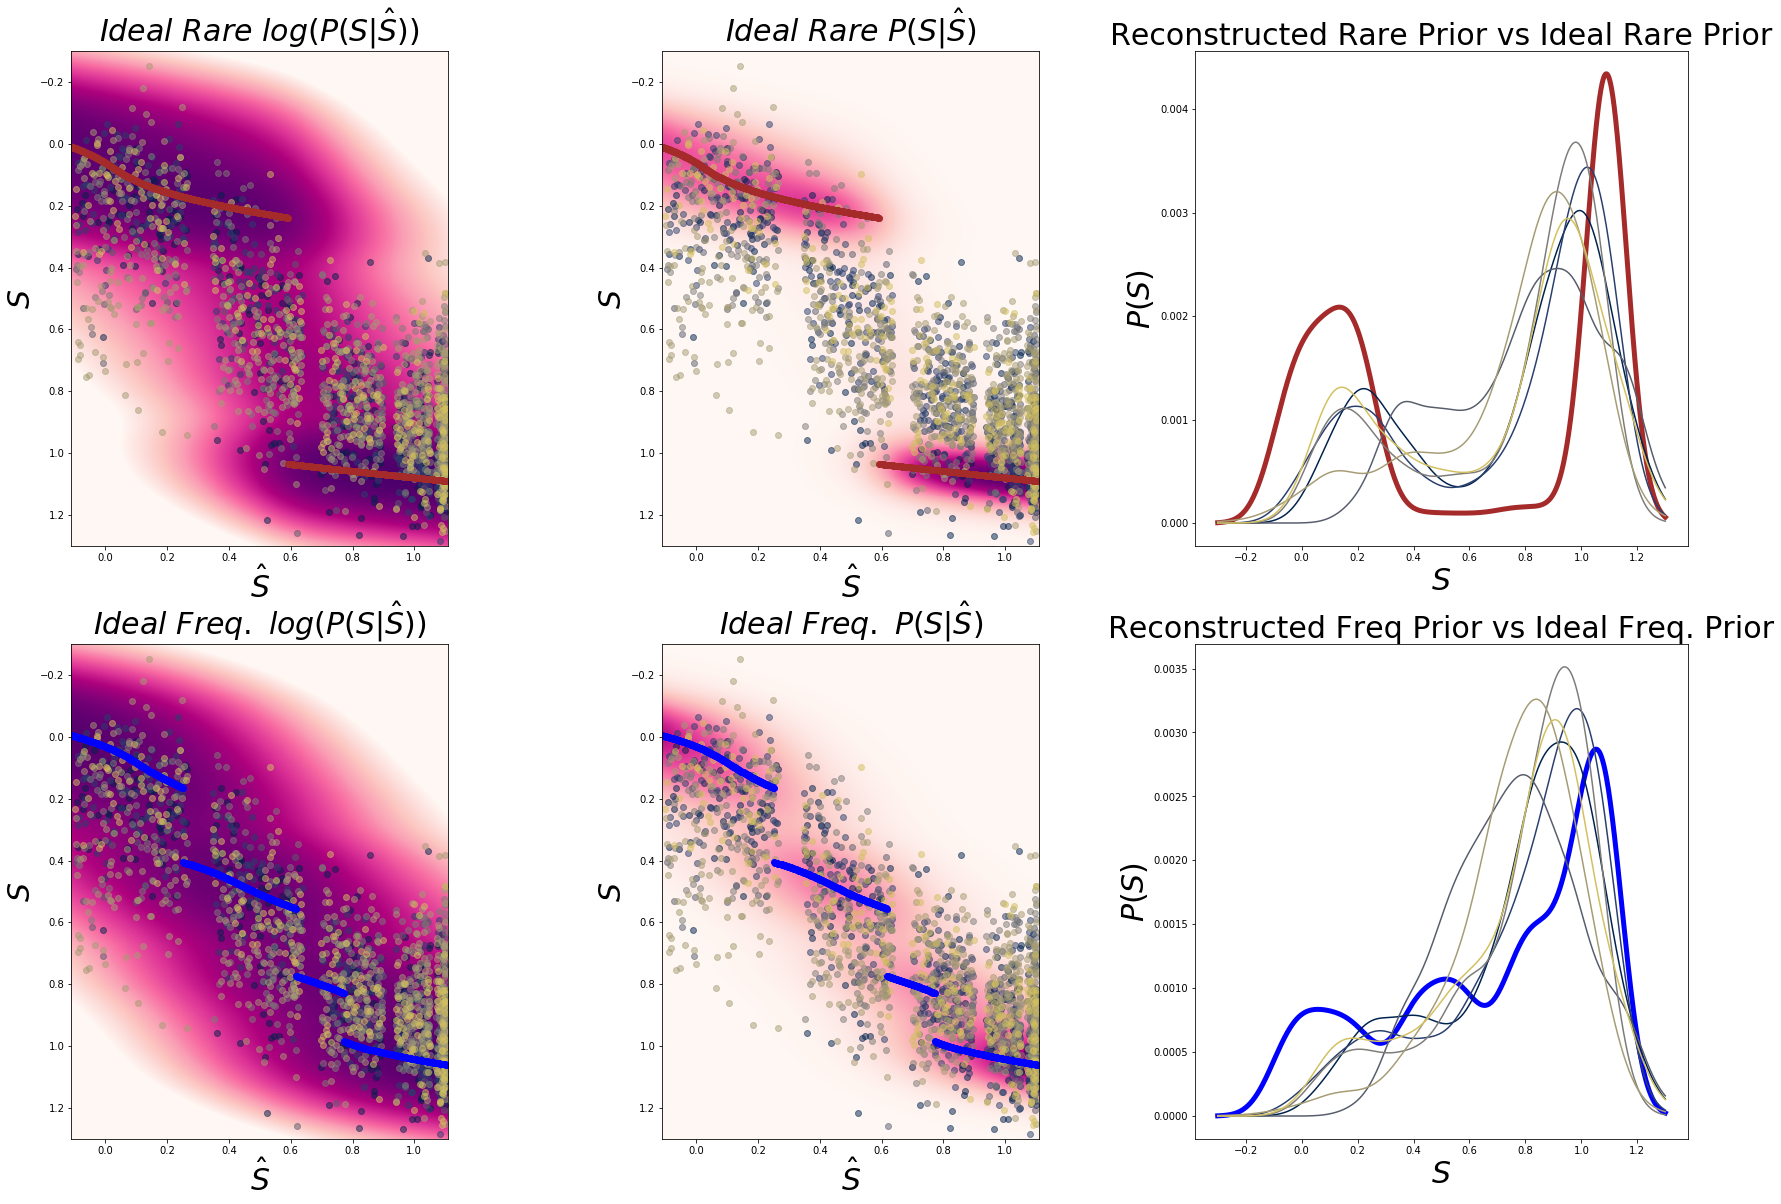

In [47]:
sigma_likelihood=.3
# x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
f,ax = plt.subplots(2,3,figsize=[30,20])

# rare_logpost = np.log(rare_post.T)
ax[0,0].imshow(rare_logpost,vmin=np.percentile(rare_logpost,20),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[0,1].imshow(rare_post.T,vmin=np.percentile(rare_post,20),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[0,2].plot(x.ravel(),rare_prior.ravel(),color='brown',linewidth=5)

# freq_logpost = np.log(freq_post.T)
ax[1,0].imshow(freq_logpost,vmin=np.percentile(freq_logpost,20),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[1,1].imshow(freq_post.T,vmin=np.percentile(freq_post,20),extent =[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[1,2].plot(x.ravel(),freq_prior.ravel(),color='blue',linewidth=5)

for i, (mouse, res) in enumerate(freq_sfreg.items()):
    _wallmorph = np.concatenate(res['wallmorph'])
    _yhat = np.concatenate(res['yhat'])
    ax[0,0].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    ax[0,1].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,0].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    ax[1,1].scatter(_wallmorph,_yhat,color=plt.cm.cividis(np.float(i/len(rare_mice))),alpha=.5)
    
    
    raresfsmooth = np.mean(gaussian(_yhat[:,np.newaxis],.1,x),axis=0)/(u.gaussian(x,.3,x[:,np.newaxis])/rareZspline(x)[np.newaxis,:]).sum(axis=1)
    freqsfsmooth = np.mean(gaussian(_yhat[:,np.newaxis],.1,x),axis=0)/(u.gaussian(x,.3,x[:,np.newaxis])/freqZspline(x)[np.newaxis,:]).sum(axis=1)
    ax[0,2].plot(x.ravel(),raresfsmooth.ravel()/raresfsmooth.sum(),color=plt.cm.cividis(np.float(i/len(freq_mice))))
    ax[1,2].plot(x.ravel(),freqsfsmooth.ravel()/freqsfsmooth.sum(),color=plt.cm.cividis(np.float(i/len(freq_mice))))
    
    rprod,fprod=(rare_prior.ravel()*raresfsmooth.ravel()).sum(),(freq_prior.ravel()*freqsfsmooth.ravel()).sum()
    print(mouse,rprod,fprod,np.log(rprod/fprod))
    
# xx = np.linspace(-.1,1.1,num=1000)
rare_ytarget = x[0,np.argmax(rare_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[0,0].scatter(xx,rare_ytarget,color='brown')
ax[0,1].scatter(xx,rare_ytarget,color='brown')

freq_ytarget = x[0,np.argmax(freq_prior*gaussian(xx[:,np.newaxis],sigma_likelihood,x),axis=1)].ravel()
ax[1,0].scatter(xx,freq_ytarget,color='blue')
ax[1,1].scatter(xx,freq_ytarget,color='blue')


ax[0,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,0].set_ylabel("$S$",fontsize=30)
ax[0,0].set_title("$Ideal \  Rare \ log(P(S|\hat{S}))$",fontsize=30)
ax[0,0].set_ylim([1.3,-.3])
ax[0,0].set_xlim([-.11,1.11])

ax[0,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[0,1].set_ylabel("$S$",fontsize=30)
ax[0,1].set_title("$Ideal \  Rare \ P(S|\hat{S})$",fontsize=30)
ax[0,1].set_ylim([1.3,-.3])
ax[0,1].set_xlim([-.11,1.11])

ax[0,2].set_xlabel("$S$",fontsize=30)
ax[0,2].set_ylabel("$P(S)$",fontsize=30)
ax[0,2].set_title("Reconstructed Rare Prior vs Ideal Rare Prior",fontsize=30)

ax[1,0].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,0].set_ylabel("$S$",fontsize=30)
ax[1,0].set_title("$Ideal \ Freq. \ log(P(S|\hat{S}))$",fontsize=30)
ax[1,0].set_ylim([1.3,-.3])
ax[1,0].set_xlim([-.11,1.11])

ax[1,1].set_xlabel("$\hat{S}$",fontsize=30)
ax[1,1].set_ylabel("$S$",fontsize=30)
ax[1,1].set_title("$Ideal \ Freq. \ P(S|\hat{S})$",fontsize=30)
ax[1,1].set_ylim([1.3,-.3])
ax[1,1].set_xlim([-.11,1.11])

ax[1,2].set_xlabel("$S$",fontsize=30)
ax[1,2].set_ylabel("$P(S)$",fontsize=30)
ax[1,2].set_title("Reconstructed Freq Prior vs Ideal Freq. Prior",fontsize=30)

f.savefig("D:\\Morph_Results\\figures\\freq_sf_reg_density.png",format="png")
f.savefig("D:\\Morph_Results\\figures\\freq_sf_reg_density.pdf",format="pdf")

### Confirming recapitualation of Unity planes

In [159]:
# ensure texture looks the same as unity

intens = lambda xs,ys, f, theta: np.cos(2.*np.pi*f*(xs*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) + ys*(np.cos(theta+np.pi/4.)-np.sin(theta+np.pi/4))))


In [160]:
f1,f2 = 2.5,3.5
theta1,theta2 = 60.,10.
morph = 1.
f = morph*f1 + (1-morph)*f2
print(f)
theta = (morph*theta1  + (1-morph)*theta2) * np.pi / 180
print(theta)
texture = np.zeros([120,1500])
for y in range(texture.shape[1]):
    for x in range(texture.shape[0]):
        xs = x/texture.shape[1]*1
        ys = y/texture.shape[0]*1
        texture[x,y]=intens(xs,ys,f,theta)#+ intens(ys,xs,f,theta)
print(xs,ys)

2.5
1.0471975511965976
0.07933333333333334 12.491666666666667


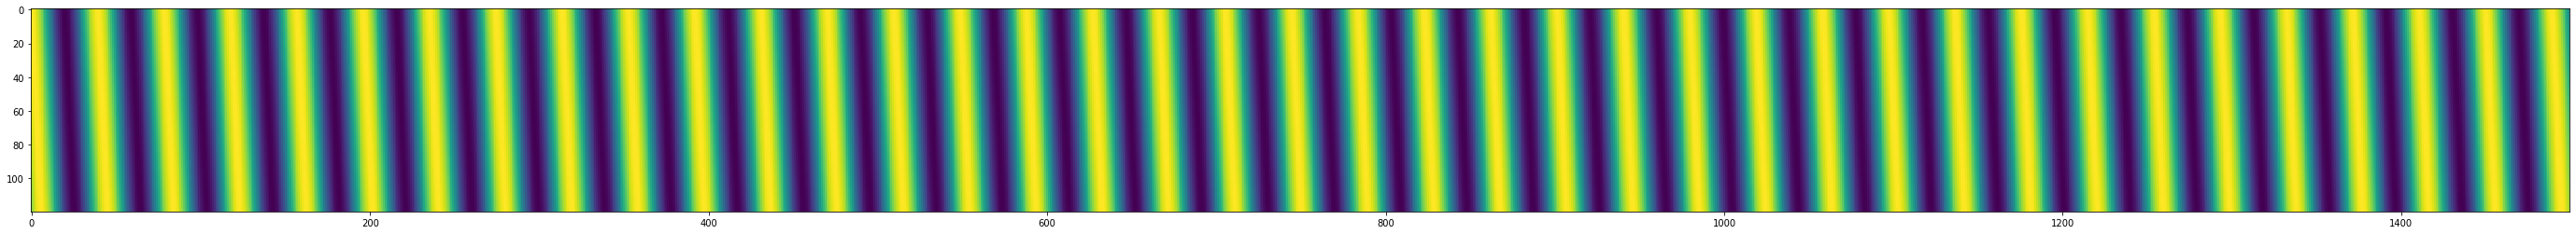

In [161]:
f,ax = plt.subplots(1,1,figsize=[50,4],sharex=True)
ax.imshow(texture)


In [197]:
xfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)-np.sin(theta+np.pi/4.)) 
yfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) 

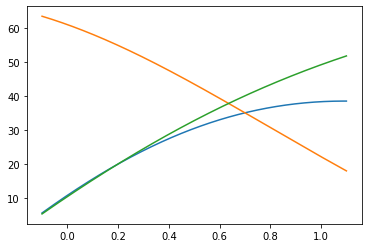

In [199]:
morphs = np.linspace(-.1,1.1,num=1000)
# xcoeff = np.zeros(morphs.shape)
f,theta = morphs*f1 + (1-morphs)*f2, (morphs*theta1  + (1-morphs)*theta2) * np.pi / 180
xcoeff = xfreq(f,theta)
ycoeff = yfreq(f,theta)
fig,ax = plt.subplots()
ax.plot(morphs,np.abs(xcoeff))
ax.plot(morphs,np.abs(ycoeff))
# ax.plot(morphs,np.abs(ycoeff))
# ang = np.abs(np.arctan(xcoeff/ycoeff)*180/np.pi)
# ax.plot(morphs,ang)

ax.plot(morphs,.5*(ang+np.abs(xcoeff)))
# ax.plot(morphs,5*np.log(np.abs(xcoeff)))

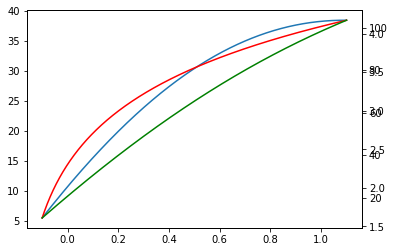

In [207]:
f,ax = plt.subplots()
ax.plot(morphs,np.abs(xcoeff))
ax2 = ax.twinx()
ax2.plot(morphs,np.log(ang),color='red')
ax3= ax.twinx()
ax3.plot(morphs,np.abs(xcoeff)+ang,color='green')